KNN Cross-Validated Results:
Accuracy: 0.52, Precision: 0.51, Recall: 0.47, F1 Score: 0.49

Naive Bayes Cross-Validated Results:
Accuracy: 0.54, Precision: 0.55, Recall: 0.55, F1 Score: 0.53


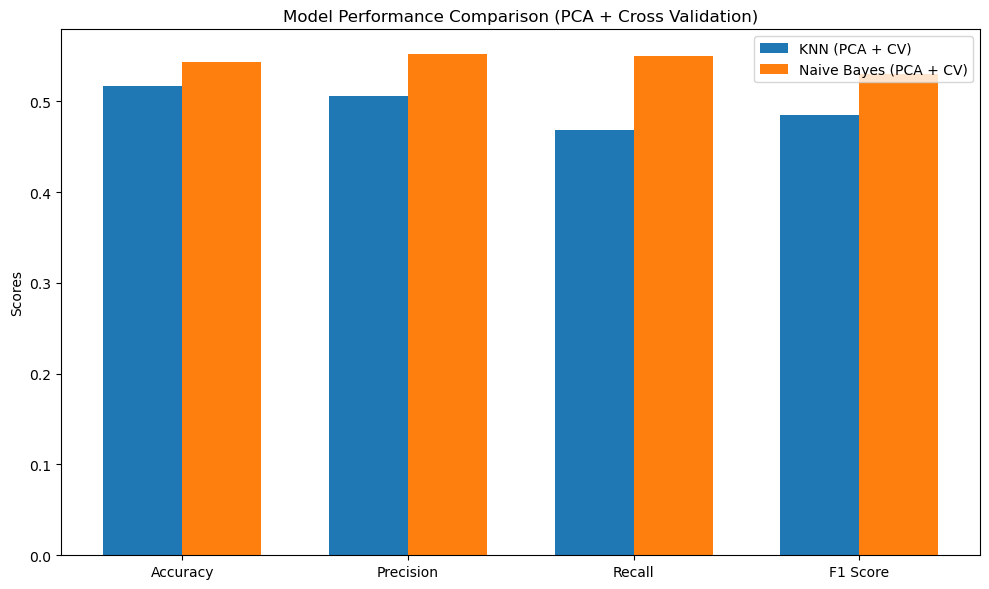

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load data
df = pd.read_csv("ABNB.csv")

# Handle missing values
df['Close'] = df['Close'].fillna(df['Close'].mean())

# Create binary target
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Features and target
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
X = df[features].values
y = df['Target'].values

# Drop last row (because Target uses shift)
X = X[:-1]
y = y[:-1]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Manual KNN function
def knn_predict(X_train, y_train, X_test_point, k=3):
    distances = [np.linalg.norm(x - X_test_point) for x in X_train]
    k_indices = np.argsort(distances)[:k]
    k_labels = [y_train[i] for i in k_indices]
    most_common = Counter(k_labels).most_common(1)[0][0]
    return most_common

# Manual Naive Bayes
def gaussian_prob(x, mean, std):
    eps = 1e-6
    return (1.0 / (np.sqrt(2 * np.pi) * (std + eps))) * np.exp(- ((x - mean) ** 2) / (2 * (std + eps) ** 2))

def naive_bayes_predict(X_train, y_train, X_test):
    labels = np.unique(y_train)
    means = {}
    stds = {}
    priors = {}

    for label in labels:
        X_l = X_train[y_train == label]
        means[label] = X_l.mean(axis=0)
        stds[label] = X_l.std(axis=0)
        priors[label] = len(X_l) / len(X_train)

    predictions = []
    for x in X_test:
        probs = {}
        for label in labels:
            prob = np.log(priors[label])
            for i in range(len(x)):
                prob += np.log(gaussian_prob(x[i], means[label][i], stds[label][i]))
            probs[label] = prob
        predicted = max(probs, key=probs.get)
        predictions.append(predicted)
    return predictions

# Evaluation metrics
def evaluate(y_true, y_pred):
    TP = sum((y_true[i] == 1 and y_pred[i] == 1) for i in range(len(y_true)))
    TN = sum((y_true[i] == 0 and y_pred[i] == 0) for i in range(len(y_true)))
    FP = sum((y_true[i] == 0 and y_pred[i] == 1) for i in range(len(y_true)))
    FN = sum((y_true[i] == 1 and y_pred[i] == 0) for i in range(len(y_true)))

    accuracy = (TP + TN) / len(y_true)
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)

    return accuracy, precision, recall, f1

# Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

knn_metrics = []
nb_metrics = []

for train_idx, test_idx in skf.split(X_pca, y):
    X_train, X_test = X_pca[train_idx], X_pca[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # KNN predictions
    y_pred_knn = [knn_predict(X_train, y_train, x, k=5) for x in X_test]
    knn_metrics.append(evaluate(y_test, y_pred_knn))

    # Naive Bayes predictions
    y_pred_nb = naive_bayes_predict(X_train, y_train, X_test)
    nb_metrics.append(evaluate(y_test, y_pred_nb))

# Average results
knn_avg = np.mean(knn_metrics, axis=0)
nb_avg = np.mean(nb_metrics, axis=0)

# Display results
print("KNN Cross-Validated Results:")
print(f"Accuracy: {knn_avg[0]:.2f}, Precision: {knn_avg[1]:.2f}, Recall: {knn_avg[2]:.2f}, F1 Score: {knn_avg[3]:.2f}")

print("\nNaive Bayes Cross-Validated Results:")
print(f"Accuracy: {nb_avg[0]:.2f}, Precision: {nb_avg[1]:.2f}, Recall: {nb_avg[2]:.2f}, F1 Score: {nb_avg[3]:.2f}")

# Visualization
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, knn_avg, width, label='KNN (PCA + CV)')
plt.bar(x + width/2, nb_avg, width, label='Naive Bayes (PCA + CV)')
plt.xticks(x, labels)
plt.ylabel('Scores')
plt.title('Model Performance Comparison (PCA + Cross Validation)')
plt.legend()
plt.tight_layout()
plt.show()
